## <center> Аттестация. Практическое задание в Jupiter

В данном блоке вам предстоит решить задачу, которую автор когда-то решал на одном из своих собеседований.
Вам предоставлена таблица с данными (скачать файл можно на платформе) о ежедневной выработке энергии солнечными батареями. Информация в ней содержится в двух столбцах: 
* date - дата наблюдения
* cum_power - накопленная (кумулятивная) выработка энергии на указанный день

То есть перед вами классический пример временного ряда: числовой показатель, зависящий от времени. Давайте с ним поработаем.


In [3]:
import pandas as pd
import numpy as np

solarpower_orig = None

def slpw_cp():
    global solarpower_orig

    if solarpower_orig is None:
        solarpower_orig = pd.read_csv('solarpower.zip')

    return solarpower_orig.copy()

slpw = slpw_cp()

# убеждаемся, что данные прочитаны
slpw.head()

,date,cum_power
0,2017-01-01,20111.0
1,2017-01-02,20112.0
2,2017-01-03,20115.0
3,2017-01-04,20117.0
4,2017-01-05,20119.0


1. В нашем временном ряде есть несколько пропусков, они обозначены числом -1. Заполните пропуски средним арифметическим между двумя соседними наблюдениями: </p>
    $$x^*_i  = \frac{x_{i-1} - x_{i+1}}{2}$$ 
    
Совет: проще всего будет сделать это, используя цикл по индексам элементов столбца cum_power, но вы можете предложить более изящное решение.


In [6]:
slpw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       664 non-null    object 
 1   cum_power  664 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.5+ KB


In [7]:
def get_fixex_cum_power(row):
    """Получает строку из таблицы и проверяет значение 
    в колонке `cum_power`. Если оно не равно -1,
    то возвращает как есть, иначе считает и возвращает 
    среднее арифметическое значений предыдущей/следующей строки.

    Args:
        row (pandas.core.series.Series): Строка из slpw DataFrame

    Raises:
        Exception: Функция отработает корректно если во всей таблице
        строки со значениями -1 в колонке `cum_power` не идут
        подряд. В противном случае будет произойдет ошибка.

    Returns:
        [np.float64]: Корректное значение ячейки `cum_power`
    """
    value = row['cum_power']

    if value > -1:
        return value

    idx = row.name
    prv = slpw.loc[idx-1, 'cum_power']
    nxt = slpw.loc[idx+1, 'cum_power']
    
    if prv == -1 or nxt == -1:
        raise Exception(f'Consecutive invalid data detected for index {idx}')
    
    return (prv+nxt) / 2

slpw['cum_power'] = slpw.apply(get_fixex_cum_power, axis=1)

2. Теперь, когда таблица заполнена, создайте столбец day_power - ежедневный прирост выработки солнечной энергии.

    После чего создайте данные о ежемесячной выработке энергии на каждый год. 
    
Совет: для того, чтобы выделить из даты год и месяц проще всего воспользоваться методом аксессора dt.to_period('M'), который позволяет выделять периоды, в данном случае 'М' - месяц.

In [9]:
# создаем новый признак с разницей значений в ячейках `cum_power`
slpw['day_power'] = slpw['cum_power'].diff()

# устанавливаем значение 0 для первой ячейки
slpw.loc[0, 'day_power'] = 0

# создаем новый признак: год и месяц наблюдения
slpw['date'] = pd.to_datetime(slpw['date'])
slpw['year_month'] = slpw['date'].dt.to_period('M')

# смотрим что получилось
slpw.head()

,date,cum_power,day_power,year_month
0,2017-01-01,20111.0,0.0,2017-01
1,2017-01-02,20112.0,1.0,2017-01
2,2017-01-03,20115.0,3.0,2017-01
3,2017-01-04,20117.0,2.0,2017-01
4,2017-01-05,20119.0,2.0,2017-01


3. Постройте график временного ряда - ежемесячной выработки солнечной энергии. Не забудьте подписать оси и сам график.
Укажите в какие сезоны наблюдается подъем, а в какие спад?

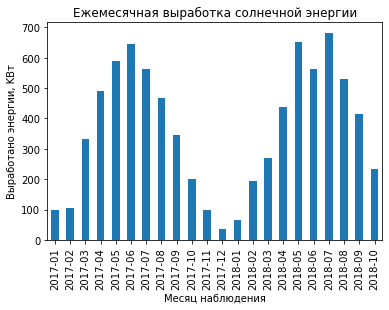

In [10]:
# группируем данные по признаку `year_month` и суммируем `day_power`
data = slpw.groupby('year_month')['day_power'].sum().reset_index()

# рисуем график средствами Pandas
ax = data.plot(x='year_month', y='day_power', grid=True, kind='bar', legend=False)

# добавляем название и подписываем координатные оси
ax.set_title('Ежемесячная выработка солнечной энергии')
ax.set_xlabel('Месяц наблюдения')
ax.set_ylabel('Выработано энергии, KВт');


### Комментарий к графику

На графике ярко выражена сезонность. Больше всего энергии вырабатывается в мае, июне и июле. Меньше всего — в ноябре, декабре и январе. В марте и апреле интенсивный рост, в сентябре и октябре резкий спад.